## Import Packages / Load Images

In [2]:
import os, sys, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import seaborn_image as isns
from IPython.display import Image as IPImage
from PIL import Image, ImageEnhance

In [52]:
original = np.array(Image.open("/Users/pkr/Codebase/research/phenotyping/pennycressUNet/data/input_image.png"))/ 255
mask = np.array(Image.open("/Users/pkr/Codebase/research/phenotyping/pennycressUNet/data/mask_image.png")) / 255

In [53]:
def mask_viz(image, mask, mask_alpha = 0.5, outlines = False, brighten=True):
  """
  Function to overlay mask on image

  Parameters:
  image (np.array): image to overlay mask on
  mask (np.array): mask to overlay on image
  mask_alpha (float): alpha value for mask overlay
  outlines (bool): whether to draw outlines on mask
  brighten (bool): whether to brighten image before overlay

  Returns:
  masked_image (np.array): image with mask overlay
  """

  # create outlines on each border

  image = image.astype(np.float64)
  mask = mask.astype(np.float64)

  if outlines:
  # create outlines on each border
    outlines = np.zeros_like(mask)
    for i in range(mask.shape[2]):
        channel = np.uint8(mask[:, :, i])
        outlines[:, :, i] = cv2.Canny(channel, 0, 1)

    outlines = np.expand_dims(np.where(outlines.sum(2) > 0 , 255, 0), -1)
    outlines = np.where(outlines > 0, 
                        (mask * 255),
                        0)
    outlines = np.uint8(outlines) / 255

  if brighten:
    # create enhancer
    enhancer = ImageEnhance.Brightness(Image.fromarray((image * 255).astype("uint8")))
    enhanced_im = enhancer.enhance(2)
    enhanced_im = np.array(enhanced_im) /255

  # weighted image
  weighted_image = cv2.addWeighted(image if not brighten else enhanced_im,
                                   (1 - mask_alpha), 
                                   mask, 
                                   mask_alpha, 
                                   0)

  if outlines: 
    weighted_image = np.where(outlines > 0,
                              outlines,
                              weighted_image)

  return weighted_image

MovieWriter ffmpeg unavailable; using Pillow instead.


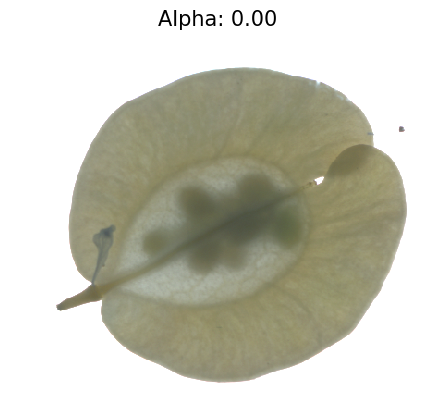

In [59]:
# options
num_frames = 80
f = r'single_mask_animation.gif'

fig, ax = plt.subplots(1,1)
ax.imshow(original[350:750, 500:950])

# write a function animate, updating mask_viz with increasing alpha
def animate(frame):
    # halfway through frames, make alpha go back down to 0
    if frame > num_frames / 2:
        alpha = 1 - (frame - num_frames / 2) / (num_frames / 2)
    else:
        alpha = frame / (num_frames / 2)
    masked_image = mask_viz(original, mask, mask_alpha=alpha)

    # clear axis
    ax.clear()
    ax.axis('off')
    ax.imshow(masked_image[350:750, 500:950])
    ax.set_title(f"Alpha: {alpha:.2f}")

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=10000000)
anim.save(f, fps=10)